In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm

data_dir = '../data/hateful_memes'
img_dir = os.path.join(data_dir, 'img')

In [2]:
print(len(os.listdir(img_dir)))

12141


In [3]:
splits = ['train', 'dev_seen', 'test_seen']
df = []
for split in splits:
    file_path = os.path.join(data_dir, f'{split}.jsonl')
    split_df = pd.read_json(file_path, lines=True)
    split_df['split'] = split
    df.append(split_df)

df = pd.concat(df, axis=0, ignore_index=True)
df['id'] = df['img'].str.split('/').str[1].str.split('.').str[0]
df.index = df['id']
df.index.name = None
print(df.shape)
df.head()


(10000, 5)


,id,img,label,text,split
42953,42953,img/42953.png,0,its their character not their color that matters,train
23058,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train
13894,13894,img/13894.png,0,putting bows on your pet,train
37408,37408,img/37408.png,0,i love everything and everybody! except for sq...,train
82403,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train


In [4]:
df['split'].value_counts()

train        8500
test_seen    1000
dev_seen      500
Name: split, dtype: int64

In [5]:
#df = df[df['split']=='train']

In [6]:
df['label'].value_counts(normalize=False)

0    6244
1    3756
Name: label, dtype: int64

In [7]:
df['text'].nunique()

8045

# Match Images based on Text

In [8]:
idx_to_text = {idx:text for idx, text in enumerate(df['text'].unique())}
text_to_idx = {v:k for k, v in idx_to_text.items()}

In [9]:
df['text_idx'] = df['text'].map(text_to_idx)
df.head()

,id,img,label,text,split,text_idx
42953,42953,img/42953.png,0,its their character not their color that matters,train,0
23058,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train,1
13894,13894,img/13894.png,0,putting bows on your pet,train,2
37408,37408,img/37408.png,0,i love everything and everybody! except for sq...,train,3
82403,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train,4


<AxesSubplot:>

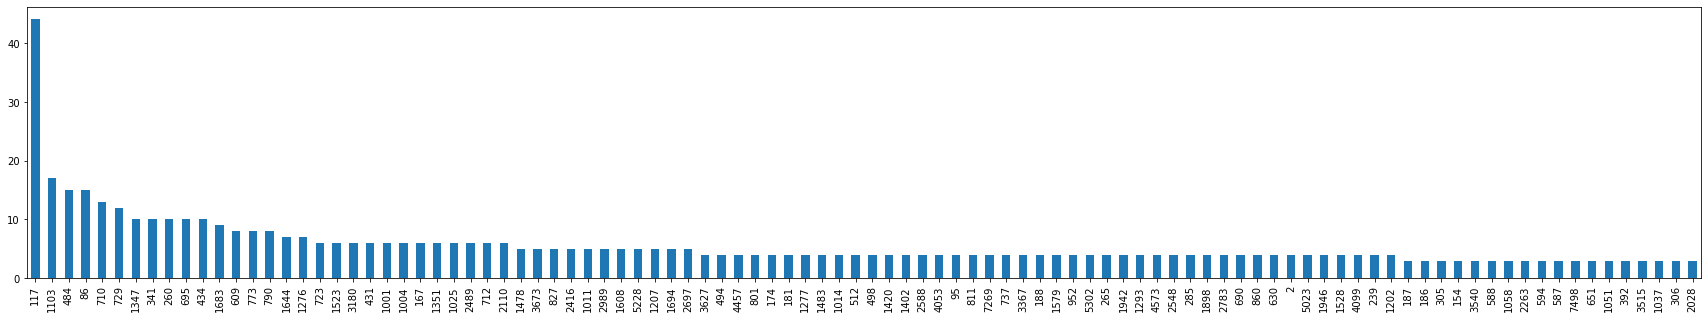

In [10]:
df['text_idx'].value_counts()[:100].plot.bar(figsize=(30,5))

In [11]:
df['text_idx'].value_counts().value_counts()

1     6548
2     1301
3      114
4       42
6       12
5       11
10       5
8        3
15       2
7        2
44       1
17       1
13       1
12       1
9        1
Name: text_idx, dtype: int64

In [12]:
# {text_id: [meme_idx_1, ...], ...}
text_idx_to_memes = df.groupby('text_idx')['id'].apply(list).to_dict()
text_idx_to_memes = {k:v for k, v in text_idx_to_memes.items() if len(v) > 1}
print(len(text_idx_to_memes))

1497


In [13]:
text_idx_to_label_to_memes = {}
for text_idx, memes in text_idx_to_memes.items():
    text_idx_to_label_to_memes[text_idx] = {}
    text_idx_to_label_to_memes[text_idx]['non-hateful'] = []
    text_idx_to_label_to_memes[text_idx]['hateful'] = []

    hateful_added, non_hateful_added = False, False
    for meme_idx in memes:
        if df.loc[meme_idx]['label'] == 0:
            text_idx_to_label_to_memes[text_idx]['non-hateful'].append(meme_idx)
            non_hateful_added = True
        else:
            text_idx_to_label_to_memes[text_idx]['hateful'].append(meme_idx)
            hateful_added = True

    if not hateful_added or not non_hateful_added:
        del text_idx_to_label_to_memes[text_idx]

    # if len(text_idx_to_label_to_memes[text_idx]['non-hateful']) == 0:
    #     del text_idx_to_label_to_memes[text_idx]['non-hateful']
    # if len(text_idx_to_label_to_memes[text_idx]['hateful']) == 0:
    #     del text_idx_to_label_to_memes[text_idx]['hateful']

print(len(text_idx_to_label_to_memes))

1043


In [14]:
list(text_idx_to_label_to_memes.items())[:10]

[(2, {'non-hateful': ['13894', '53027'], 'hateful': ['59817', '96180']}),
 (8, {'non-hateful': ['02973'], 'hateful': ['39785']}),
 (13, {'non-hateful': ['19324'], 'hateful': ['95278']}),
 (21, {'non-hateful': ['70146'], 'hateful': ['20497']}),
 (37, {'non-hateful': ['51846'], 'hateful': ['28396']}),
 (38, {'non-hateful': ['01569'], 'hateful': ['83579']}),
 (40, {'non-hateful': ['06418'], 'hateful': ['83152']}),
 (48, {'non-hateful': ['34217'], 'hateful': ['74386', '39625']}),
 (54, {'non-hateful': ['27401'], 'hateful': ['36872']}),
 (56, {'non-hateful': ['25473'], 'hateful': ['47859']})]

In [15]:
df.loc['07481']

id                                            07481
img                                   img/07481.png
label                                             0
text        when you see your goat with another man
split                                         train
text_idx                                       3154
Name: 07481, dtype: object

{'non-hateful': ['86203'], 'hateful': ['03479']}


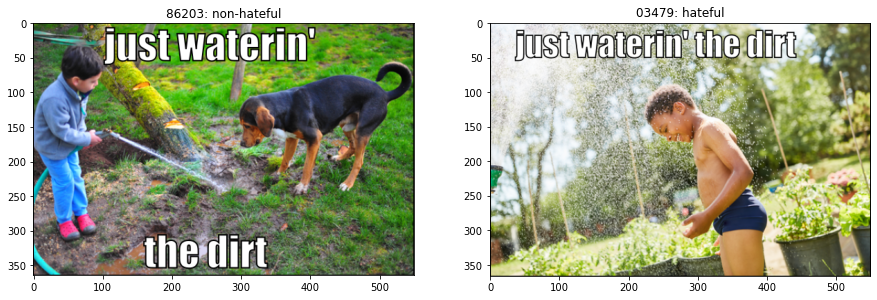

In [16]:
sample_text_idx = np.random.choice(list(text_idx_to_label_to_memes.keys()))
print(text_idx_to_label_to_memes[sample_text_idx])
meme_idx_1 = np.random.choice(text_idx_to_label_to_memes[sample_text_idx]['non-hateful'])
meme_idx_2 = np.random.choice(text_idx_to_label_to_memes[sample_text_idx]['hateful'])

fig, axes = plt.subplots(1, 2, figsize=(15,10))
axes[0].imshow(Image.open(f'{img_dir}/{meme_idx_1}.png'))
axes[1].imshow(Image.open(f'{img_dir}/{meme_idx_2}.png'))
axes[0].set_title(f'{meme_idx_1}: non-hateful')
axes[1].set_title(f'{meme_idx_2}: hateful')
plt.show()

# Grouping similar sentences

In [17]:
import spacy
from multiprocessing import Pool

nlp = spacy.load("en_core_web_md")

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [18]:
def get_simlarity(text1, text2, method='spacy'):
    """
    src: https://stackoverflow.com/questions/65199011/is-there-a-way-to-check-similarity-between-two-full-sentences-in-python
    """

    if method == 'jaccard':
        text1 = set(text1.lower().split(" "))
        text2 = set(text2.lower().split(" "))
        score = len(text1.intersection(text2)) / len(text1.union(text2))
    elif method == 'spacy':
        embed1 = nlp(text1)
        embed2 = nlp(text2)
        score = embed1.similarity(embed2)
    else:
        raise ValueError

    return score

In [19]:
meme_idx_to_text = df['text'].to_dict()
meme_idxs = list(meme_idx_to_text.keys())
scores = np.zeros((len(meme_idxs), len(meme_idxs)))

for i in tqdm(range(len(meme_idxs))):
    for j in range(i+1, len(meme_idxs)):
        text_i = meme_idx_to_text[meme_idxs[i]]
        text_j = meme_idx_to_text[meme_idxs[j]]
        score = get_simlarity(text_i, text_j, method='jaccard')
        scores[i, j] = score
        scores[j, i] = score

# with Pool(2) as pool:
#     pool.map(compute_similarity, range(len(text_idxs)))
#     # for _ in tqdm(pool.imap_unordered(compute_similarity, text_ids), total=len(text_ids)):
#     #     pass

  0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
sentences = list(meme_idx_to_text.values())
sentence_embeddings = model.encode(sentences)
print(sentence_embeddings.shape, type(sentence_embeddings))

(10000, 768) <class 'numpy.ndarray'>


In [21]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
scores_tr = cosine_similarity(sentence_embeddings)
for i in range(len(scores_tr)):
    scores_tr[i, i] = 0
print(scores_tr.shape)
print(scores_tr.min(), scores_tr.max())

(10000, 10000)
-0.40539545 1.0000005


In [22]:
i_idxs, j_idxs = np.where((scores>0.7) & (scores_tr>0.7))
print(len(i_idxs))
for i, j in zip(i_idxs[:5], j_idxs[:5]):
    print(meme_idxs[i], meme_idxs[j],  f'jaccard: {scores[i, j]}; tr: {scores_tr[i, j]}')
    print(meme_idx_to_text[meme_idxs[i]], '\n', meme_idx_to_text[meme_idxs[j]], '\n')
    

10518
13894 59817 jaccard: 1.0; tr: 1.0000001192092896
putting bows on your pet 
 putting bows on your pet 

13894 53027 jaccard: 1.0; tr: 1.0000001192092896
putting bows on your pet 
 putting bows on your pet 

13894 96180 jaccard: 1.0; tr: 0.9999999403953552
putting bows on your pet 
 putting bows on your pet 

70914 97623 jaccard: 0.8888888888888888; tr: 0.99876868724823
tattoos are bad for your health i know 5 million people that had tattoos and they all died 
 tattoos are bad for your health i know 5 million people who had tattoos and they all died 

70914 98531 jaccard: 1.0; tr: 0.9999998211860657
tattoos are bad for your health i know 5 million people that had tattoos and they all died 
 tattoos are bad for your health i know 5 million people that had tattoos and they all died 



In [23]:
meme_idxs = list(meme_idx_to_text.keys())
psuedo_text_idx_to_meme_idxs = {}
for i, j in zip(i_idxs, j_idxs):
    for k in range(len(psuedo_text_idx_to_meme_idxs)):
        if meme_idxs[i] in psuedo_text_idx_to_meme_idxs[k] or meme_idxs[j] in psuedo_text_idx_to_meme_idxs[k]:
            psuedo_text_idx_to_meme_idxs[k].update({meme_idxs[i], meme_idxs[j]})
            break
    else:
        psuedo_text_idx_to_meme_idxs[len(psuedo_text_idx_to_meme_idxs)] = {meme_idxs[i], meme_idxs[j]}
print(len(psuedo_text_idx_to_meme_idxs))

1743


In [24]:
#psuedo_text_idx_to_meme_idxs

In [25]:
meme_idx_to_psuedo_text_idx = {}
for psuedo_text_idx, meme_idxs in psuedo_text_idx_to_meme_idxs.items():
    for meme_idx in meme_idxs:
        meme_idx_to_psuedo_text_idx[meme_idx] = psuedo_text_idx
print(len(meme_idx_to_psuedo_text_idx))

# for meme idxs that are not covered
non_covered_meme_idxs = set(df['id'].values) - set(meme_idx_to_psuedo_text_idx.keys())
for i, non_covered_meme_idx in enumerate(non_covered_meme_idxs, start=len(psuedo_text_idx_to_meme_idxs)):
    meme_idx_to_psuedo_text_idx[non_covered_meme_idx] = i
print(len(meme_idx_to_psuedo_text_idx))

4244
10000


In [26]:
df['pseudo_text_idx'] = df['id'].map(meme_idx_to_psuedo_text_idx)

In [27]:
df.describe()

,label,text_idx,pseudo_text_idx
count,10000.000000,10000.000000,10000.000000
mean,0.375600,3808.343200,2996.132300
std,0.484302,2370.330576,2297.623341
min,0.000000,0.000000,0.000000
25%,0.000000,1685.750000,920.000000
50%,0.000000,3681.500000,2498.500000
75%,1.000000,5843.250000,4998.250000
max,1.000000,8044.000000,7498.000000


In [28]:
df.head()

,id,img,label,text,split,text_idx,pseudo_text_idx
42953,42953,img/42953.png,0,its their character not their color that matters,train,0,4901
23058,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train,1,3620
13894,13894,img/13894.png,0,putting bows on your pet,train,2,0
37408,37408,img/37408.png,0,i love everything and everybody! except for sq...,train,3,4451
82403,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train,4,5609


# Find Image index

In [29]:
from skimage.metrics import structural_similarity as compare_ssim
import imutils
import cv2

In [30]:
#imgs = [cv2.resize(cv2.imread(f'{data_dir}/{img_fp}', 0), (128, 128)) for img_fp in df['img'].values]
#len(imgs)

In [31]:
#plt.imshow(imgs[2], cmap='gray')

In [32]:
# scores_ssim = np.zeros((len(imgs), len(imgs)))
# for i in tqdm(range(len(imgs))):
#     for j in range(i+1, len(imgs)):
#         (score, diff) = compare_ssim(imgs[i], imgs[j], full=True)
#         scores_ssim[i, j] = score

In [33]:
import torch
from torchvision.models import resnet18 

model = resnet18(pretrained=True)
model.eval()
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
x = torch.randn([1,3,224,224])
output = feature_extractor(x) 
print(output.shape)

torch.Size([1, 512, 1, 1])


/home/gokul_kumar/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [34]:
from PIL import Image
import torchvision.transforms as T

transforms = T.Compose([T.Resize(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

imgs = []
for img_fp in tqdm(df['img'].values.tolist()):
    img = Image.open(f'{data_dir}/{img_fp}').convert('RGB').resize((224, 224))
    img = transforms(img).unsqueeze(dim=0)
    imgs.append(img)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [35]:
imgs = torch.cat(imgs, dim=0)
print(imgs.shape)

torch.Size([10000, 3, 224, 224])


In [36]:
batch_size = 100
assert len(imgs) % batch_size == 0
num_batches = len(imgs) // batch_size
imgs_features = []
for i in tqdm(range(num_batches)):
    start_idx = i*batch_size
    end_idx = start_idx + batch_size
    imgs_features_batch = feature_extractor(imgs[start_idx:end_idx])
    imgs_features_batch = imgs_features_batch.squeeze().detach().numpy()
    imgs_features.append(imgs_features_batch)
imgs_features = np.concatenate(imgs_features)
print(imgs_features.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(10000, 512)


In [37]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
scores_img = cosine_similarity(imgs_features)
for i in range(len(scores_img)):
    scores_img[i, i] = 0
print(scores_img.shape)
print(scores_img.min(), scores_img.max())

(10000, 10000)
0.0 0.99947596


14556
42953 51683 scores_img: 0.9826446771621704


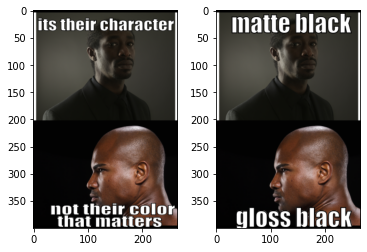

82403 71038 scores_img: 0.923524022102356


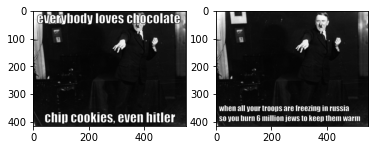

16952 92738 scores_img: 0.94631427526474


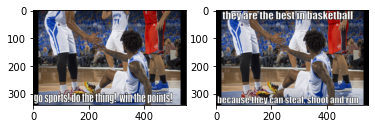

In [38]:
i_idxs, j_idxs = np.where((scores_img>0.92) & (scores_img<1))
print(len(i_idxs))
meme_idx_to_img = df['img'].to_dict()
meme_idxs = list(meme_idx_to_img.keys())
for i, j in zip(i_idxs[:3], j_idxs[:3]):
    print(meme_idxs[i], meme_idxs[j],  f'scores_img: {scores_img[i, j]}')
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(Image.open(f'{data_dir}/{meme_idx_to_img[meme_idxs[i]]}'))
    axes[1].imshow(Image.open(f'{data_dir}/{meme_idx_to_img[meme_idxs[j]]}'))
    plt.show()
    
    

In [39]:
meme_idxs = list(meme_idx_to_img.keys())
psuedo_img_idx_to_meme_idxs = {}
for i, j in zip(i_idxs, j_idxs):
    for k in range(len(psuedo_img_idx_to_meme_idxs)):
        if meme_idxs[i] in psuedo_img_idx_to_meme_idxs[k] or meme_idxs[j] in psuedo_img_idx_to_meme_idxs[k]:
            psuedo_img_idx_to_meme_idxs[k].update({meme_idxs[i], meme_idxs[j]})
            break
    else:
        psuedo_img_idx_to_meme_idxs[len(psuedo_img_idx_to_meme_idxs)] = {meme_idxs[i], meme_idxs[j]}
print(len(psuedo_img_idx_to_meme_idxs))

1641


In [40]:
#psuedo_img_idx_to_meme_idxs

In [41]:
meme_idx_to_psuedo_img_idx = {}
for psuedo_img_idx, meme_idxs in psuedo_img_idx_to_meme_idxs.items():
    for meme_idx in meme_idxs:
        meme_idx_to_psuedo_img_idx[meme_idx] = psuedo_img_idx
print(len(meme_idx_to_psuedo_img_idx))

# for meme idxs that are not covered
non_covered_meme_idxs = set(df['id'].values) - set(meme_idx_to_psuedo_img_idx.keys())
for i, non_covered_meme_idx in enumerate(non_covered_meme_idxs, start=len(psuedo_img_idx_to_meme_idxs)):
    meme_idx_to_psuedo_img_idx[non_covered_meme_idx] = i
print(len(meme_idx_to_psuedo_img_idx))

4289
10000


In [42]:
df['pseudo_img_idx'] = df['id'].map(meme_idx_to_psuedo_img_idx)

In [43]:
df.head()

,id,img,label,text,split,text_idx,pseudo_text_idx,pseudo_img_idx
42953,42953,img/42953.png,0,its their character not their color that matters,train,0,4901,0
23058,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train,1,3620,3486
13894,13894,img/13894.png,0,putting bows on your pet,train,2,0,3956
37408,37408,img/37408.png,0,i love everything and everybody! except for sq...,train,3,4451,4313
82403,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train,4,5609,1


In [44]:
df.nunique()

id                 10000
img                10000
label                  2
text                8045
split                  3
text_idx            8045
pseudo_text_idx     7499
pseudo_img_idx      7352
dtype: int64

In [45]:
file_path = f'{data_dir}/info.csv'
df.to_csv(file_path, index=False)